In [1]:
import os
import re 
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

import xarray as xr
import cartopy.crs as ccrs

In [2]:
from dask.distributed import Client
client = Client()

Task exception was never retrieved
future: <Task finished name='Task-6723363' coro=<Client._gather.<locals>.wait() done, defined at /home/groups/aditis2/robcking/am4_error_prop/lib/python3.12/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/home/groups/aditis2/robcking/am4_error_prop/lib/python3.12/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-6723165' coro=<Client._gather.<locals>.wait() done, defined at /home/groups/aditis2/robcking/am4_error_prop/lib/python3.12/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/home/groups/aditis2/robcking/am4_error_prop/lib/python3.12/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-6723170

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 64,Total memory: 96.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42299,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 64
Started: Just now,Total memory: 96.00 GiB
Comm: tcp://127.0.0.1:35285,Total threads: 8
Dashboard: http://127.0.0.1:44482/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:38252,


In [4]:
NAME = 'MAM'
FILE = 'apr'

In [5]:

BASE_DIR = f"/scratch/users/robcking/am4_error_growth_full/{FILE}"


## load in runs

In [6]:
full_memberlist = sorted(glob(os.path.join(BASE_DIR,'**','atmos_4xdaily.nc')),key=lambda x: int(re.search(r'\w+\/(\d+)\/\w+.nc',x).group(1)))
full_members =  xr.open_mfdataset(full_memberlist,combine='nested',concat_dim='members',chunks={'time':10,'pfull':'auto','grid_yt':'auto'}).isel(time=slice(250))

In [7]:
full_members


<xarray.Dataset>
Dimensions:       (time: 250, pfull: 33, phalf: 34, grid_yt: 360, members: 20,
                   bnds: 2, grid_xt: 576)
Coordinates:
  * time          (time) object 1979-04-01 06:00:00 ... 1979-06-02 12:00:00
  * pfull         (pfull) float64 2.164 5.845 10.75 17.11 ... 985.4 992.8 997.9
  * phalf         (phalf) float64 1.0 4.0 8.186 13.79 ... 989.7 995.9 1e+03
  * grid_yt       (grid_yt) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * grid_xt       (grid_xt) float64 0.3125 0.9375 1.562 ... 358.4 359.1 359.7
Dimensions without coordinates: members, bnds
Data variables:
    grid_yt_bnds  (members, grid_yt, bnds) float64 dask.array<chunksize=(1, 360, 2), meta=np.ndarray>
    grid_xt_bnds  (members, grid_xt, bnds) float64 dask.array<chunksize=(1, 576, 2), meta=np.ndarray>
    ucomp         (members, time, pfull, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 10, 23, 252, 576), meta=np.ndarray>
    vcomp         (members, time, pfull, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 10, 23, 252, 576), meta=np.ndarray>
    u_ref         (members, time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 10, 360, 576), meta=np.ndarray>
    v_ref         (members, time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 10, 360, 576), meta=np.ndarray>
    t_ref         (members, time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 10, 360, 576), meta=np.ndarray>
    temp          (members, time, pfull, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 10, 23, 252, 576), meta=np.ndarray>
    hght          (members, time, pfull, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 10, 23, 252, 576), meta=np.ndarray>
    zsurf         (members, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
Attributes:
    title:                 c96L33_am4p0
    grid_type:             regular
    grid_tile:             N/A
    code_release_version:  2023.01.02
    git_hash:              8176c2b45079431f2053ec773253938f8aee4828
    creationtime:          Tue Mar  5 15:49:03 2024
    hostname:              sh03-09n49.int
    history:               fregrid --input_mosaic INPUT/C96_mosaic.nc --input...

In [8]:
ref = full_members.isel(members=0)
members = full_members.drop_isel(members=0)

### reference diagnostic profile

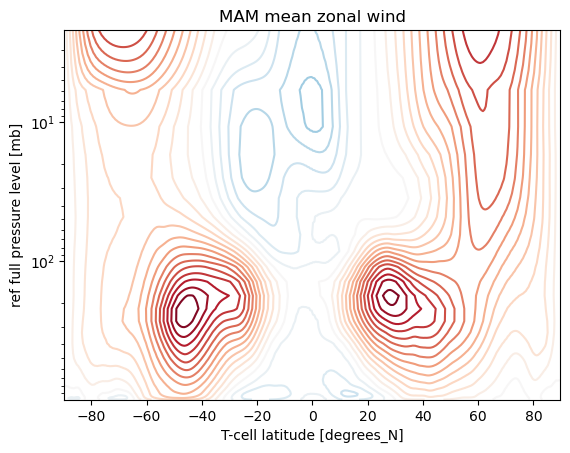

In [9]:
ref.ucomp.isel(time=slice(None,120)).mean(dim=['grid_xt','time']).plot.contour(x='grid_yt',y='pfull',levels=30,yincrease=False,yscale='log')
plt.gca().set_title(f'{NAME} mean zonal wind') 
plt.savefig(f"{NAME}/{NAME}_ex0_u_xsection.png")


In [10]:
Rcp = 0.286 # R/cp for dry atmosphere
ref_pt = ref.temp*(1000/ref.pfull)**(Rcp)

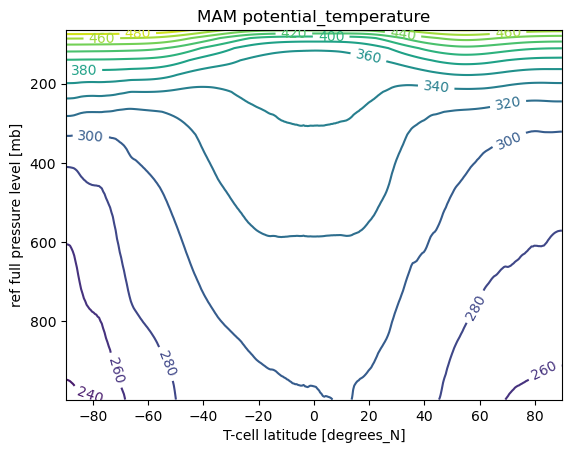

In [11]:
contour = ref_pt.sel(pfull=slice(50,None)).isel(time=slice(None,120)).mean(dim=('grid_xt','time')).plot.contour(x='grid_yt',y='pfull',levels=15,yincrease=False)
plt.clabel(contour, contour.levels, inline=True, fontsize=10)
plt.gca().set_title(f"{NAME} potential_temperature")
plt.savefig(f"{NAME}/{NAME}_ex0_potential_temp.png")

## Plot Ensemble Member history

In [12]:
square_residual = (members - ref)**2
eq = np.sqrt(square_residual['ucomp'].sel(grid_yt=slice(-10,10)).sel(pfull=850,method='nearest').mean(dim=("grid_xt", "grid_yt")))
midlat = np.sqrt(square_residual['ucomp'].sel(grid_yt=slice(30,60)).sel(pfull=850,method='nearest').mean(dim=("grid_xt", "grid_yt")))
polar = np.sqrt(square_residual['ucomp'].sel(grid_yt=slice(60,90)).sel(pfull=850,method='nearest').mean(dim=("grid_xt", "grid_yt")))

0
1
2
3
4
5
6
7
8
9
10
11
12
14
15
16
17
18


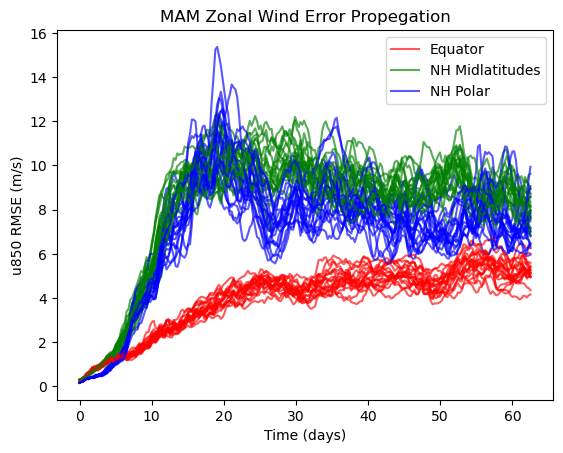

In [13]:
fig,ax = plt.subplots()
x = np.linspace(0,250*6/24,250)
for i in range(len(full_memberlist)-1):
    print(i)
    if i == 0:
        ax.plot(x,eq.isel(members=i).values,alpha=0.65,color='red',label='Equator')
        ax.plot(x,midlat.isel(members=i).values,alpha=0.65,color='green',label='NH Midlatitudes')
        ax.plot(x,polar.isel(members=i).values,alpha=0.65,color='blue',label='NH Polar')
    else:
        ax.plot(x,eq.isel(members=i).values,alpha=0.65,color='red')
        ax.plot(x,midlat.isel(members=i).values,alpha=0.65,color='green')
        ax.plot(x,polar.isel(members=i).values,alpha=0.65,color='blue')
ax.legend()
ax.set_ylabel("u850 RMSE (m/s)")
ax.set_xlabel("Time (days)")
ax.set_title(f"{NAME} Zonal Wind Error Propegation")
plt.savefig(f'{NAME}/{NAME}_mean_u850_error_sat.png')

## Max error

In [14]:
rmse = np.sqrt(square_residual.mean(dim='members'))

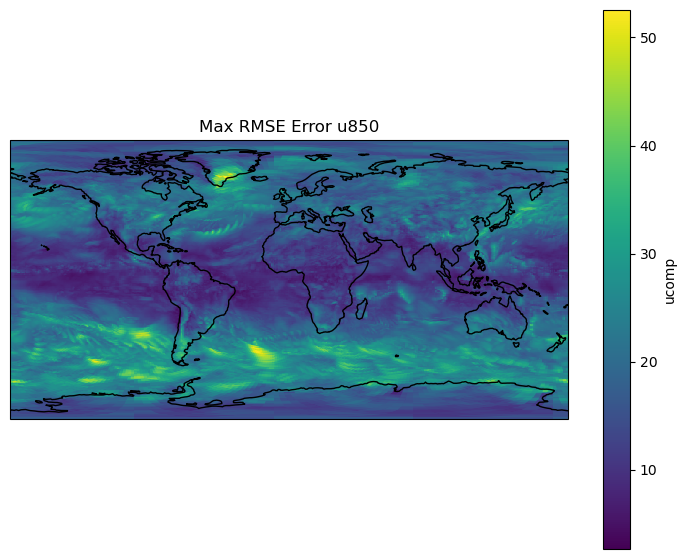

In [15]:
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection=ccrs.PlateCarree())
rmse.ucomp.sel(pfull=850,method='nearest').max(dim='time').plot.pcolormesh(ax=ax)
ax.coastlines()
ax.set_title("Max RMSE Error u850")
plt.savefig(f'{NAME}/{NAME}_max_rmse_u850.png')

### smoothed history - do error with respect to each simulation

In [16]:
rmse_member = []
for i in range(len(full_memberlist)):
    ref = full_members.isel(members=0)
    members = full_members.drop_isel(members=0)
    # Calculate RMSE
    square_residual = (members - ref) ** 2
    rmse_member.append(np.sqrt(square_residual.mean(dim='members')))

rmse = xr.concat(rmse_member,dim='members')
rmse


<xarray.Dataset>
Dimensions:       (members: 20, grid_yt: 360, bnds: 2, grid_xt: 576, time: 250,
                   pfull: 33, phalf: 34)
Coordinates:
  * time          (time) object 1979-04-01 06:00:00 ... 1979-06-02 12:00:00
  * pfull         (pfull) float64 2.164 5.845 10.75 17.11 ... 985.4 992.8 997.9
  * phalf         (phalf) float64 1.0 4.0 8.186 13.79 ... 989.7 995.9 1e+03
  * grid_yt       (grid_yt) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * grid_xt       (grid_xt) float64 0.3125 0.9375 1.562 ... 358.4 359.1 359.7
Dimensions without coordinates: members, bnds
Data variables:
    grid_yt_bnds  (members, grid_yt, bnds) float64 dask.array<chunksize=(1, 360, 2), meta=np.ndarray>
    grid_xt_bnds  (members, grid_xt, bnds) float64 dask.array<chunksize=(1, 576, 2), meta=np.ndarray>
    ucomp         (members, time, pfull, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 10, 23, 252, 576), meta=np.ndarray>
    vcomp         (members, time, pfull, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 10, 23, 252, 576), meta=np.ndarray>
    u_ref         (members, time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 10, 360, 576), meta=np.ndarray>
    v_ref         (members, time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 10, 360, 576), meta=np.ndarray>
    t_ref         (members, time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 10, 360, 576), meta=np.ndarray>
    temp          (members, time, pfull, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 10, 23, 252, 576), meta=np.ndarray>
    hght          (members, time, pfull, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 10, 23, 252, 576), meta=np.ndarray>
    zsurf         (members, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>

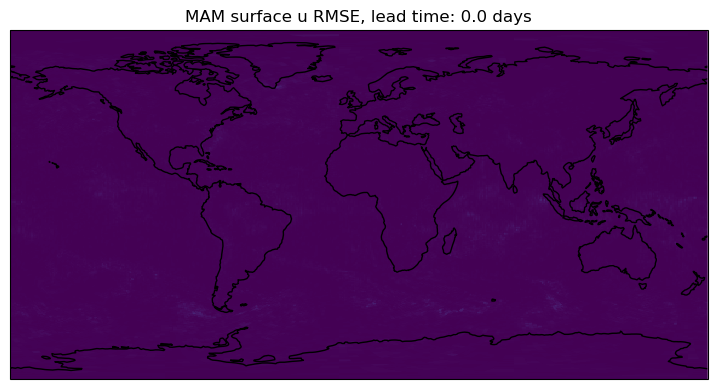

In [17]:
from matplotlib.animation import FuncAnimation

rmse_avg = rmse.mean(dim='members')
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
#im = rmse_avg.u_ref.isel(time=0).plot.imshow(ax=ax,vmin=0,vmax=20,transform=ccrs.PlateCarree(central_longitude=180),animated=True)
ax.pcolormesh(rmse_avg.grid_xt,rmse_avg.grid_yt,rmse_avg.u_ref.isel(time=0),vmin=0,vmax=20,transform=ccrs.PlateCarree(),)
ax.coastlines()

def animate(i):
    # rmse_avg.u_ref.isel(time=0).plot.imshow(ax=ax,vmin=0,vmax=20,transform=ccrs.PlateCarree(central_longitude=180),animated=True)
    ax.set_title(f"{NAME} surface u RMSE, lead time: {i/4} days")
    ax.pcolormesh(rmse_avg.grid_xt,rmse_avg.grid_yt,rmse_avg.u_ref.isel(time=i),vmin=0,vmax=20,transform=ccrs.PlateCarree(),)
ani = FuncAnimation(fig,animate,frames=100,blit=False)

In [18]:
ani.save(f'{NAME}/{NAME}_usrf_error_growth.mp4')

### horizontal time to error propegation

In [19]:
ROLLING_AVG_DAYS = 10
AM4_THRESHOLD = 0.03

In [20]:
rolling_avg = rmse.mean(dim='members').rolling(dim={'time':4*ROLLING_AVG_DAYS},center=True).mean()
rel_diff = (rolling_avg.isel(time=slice(1,None)) - rolling_avg.isel(time=slice(-1)))/(rolling_avg.isel(time=slice(-1)))
tts = ((rolling_avg > rolling_avg.mean(dim='time')*0.5) & (rel_diff < AM4_THRESHOLD)).u_ref.argmax(dim='time')*6/24


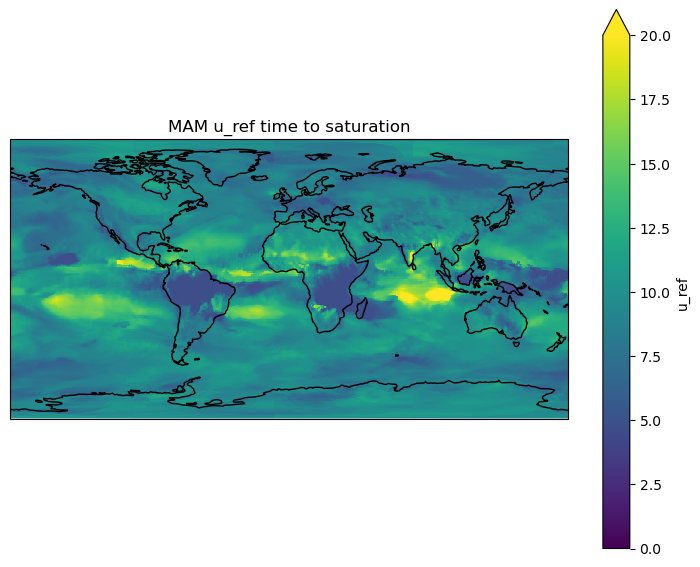

In [21]:
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection=ccrs.PlateCarree())
tts.plot.pcolormesh(ax=ax,vmax=20,vmin=0)
ax.coastlines()
ax.set_title(f"{NAME} u_ref time to saturation")
plt.savefig(f'{NAME}/{NAME}_u_ref_tts.png')

In [27]:
rmse.mean(dim='members').to_netcdf(f'/scratch/users/robcking/am4_error_growth_full/{NAME}_rmse.nc')

2024-04-10 14:26:31,860 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('broadcast_to-concatenate-getitem-open_dataset-ucomp-getitem-2c3e540e34a13b416aaa25eb0b3576d1', 0, 24, 1, 1, 0))" coro=<Worker.execute() done, defined at /home/groups/aditis2/robcking/am4_error_prop/lib/python3.12/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2024-04-10 14:26:31,861 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('broadcast_to-concatenate-getitem-open_dataset-ucomp-getitem-2c3e540e34a13b416aaa25eb0b3576d1', 0, 4, 0, 1, 0))" coro=<Worker.execute() done, defined at /home/groups/aditis2/robcking/am4_error_prop/lib/python3.12/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2024-04-10 14:26:31,861 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('broadcast_to-concatenate-getitem-o

KeyboardInterrupt: 

### Error Propegation zonal vs p

In [ ]:
zonal_rmse = rmse.mean(dim=('members','grid_xt')).sel(pfull=slice(1,None))
zonal_rmse = zonal_rmse.rolling(dim={'time':4*ROLLING_AVG_DAYS},center=True).mean()
rel_diff = (zonal_rmse.isel(time=slice(1,None)) - zonal_rmse.isel(time=slice(-1)))/(zonal_rmse.isel(time=slice(-1)))
zonal_tts = ((zonal_rmse > zonal_rmse.mean(dim='time')*0.5) & (rel_diff < AM4_THRESHOLD))[['ucomp','vcomp','temp','hght']]
zonal_tts = (zonal_tts.argmax(dim='time')*6)/24
zonal_tts.to_netcdf(f'/scratch/users/robcking/am4_error_growth_full/{NAME}_zonal_tts.nc')

2024-04-10 14:26:44,775 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/home/groups/aditis2/robcking/am4_error_prop/lib/python3.12/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/groups/aditis2/robcking/am4_error_prop/lib/python3.12/asyncio/base_events.py", line 685, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/home/groups/aditis2/robcking/am4_error_prop/lib/python3.12/site-packages/distributed/nanny.py", line 983, in run
    await worker.finished()
  File "/home/groups/aditis2/robcking/am4_error_prop/lib/python3.12/site-packages/distributed/core.py", line 630, in finished
    await self._event_finished.wait()
  File "/home/groups/aditis2/robcking/am4_error_prop/lib/python3.12/asyncio/locks.py", line 212, in wait
    await fut
asyncio.exceptions.Cance

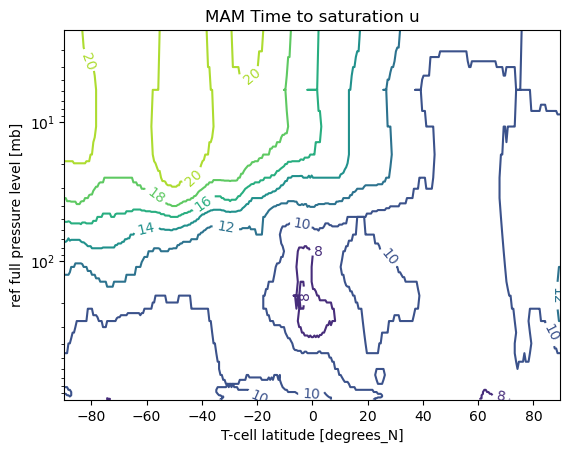

In [23]:
CS = zonal_tts.ucomp.plot.contour(levels=10,x='grid_yt',y='pfull',yincrease=False,yscale='log')
plt.gca().clabel(CS, CS.levels, inline=True, fontsize=10)
plt.gca().set_title(f"{NAME} Time to saturation u")
plt.savefig(f"{NAME}/{NAME}_tts_ucomp_pvlat.png")

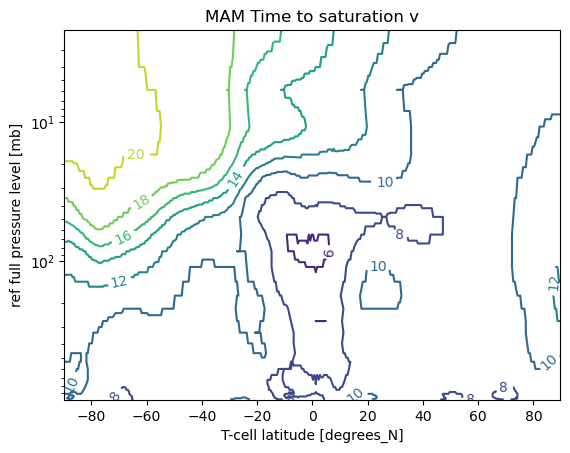

In [24]:
CS = zonal_tts.vcomp.plot.contour(levels=10,x='grid_yt',y='pfull',yincrease=False,yscale='log')
plt.gca().clabel(CS, CS.levels, inline=True, fontsize=10)
plt.gca().set_title(f"{NAME} Time to saturation v")
plt.savefig(f"{NAME}/{NAME}_tts_vcomp_pvlat.png")

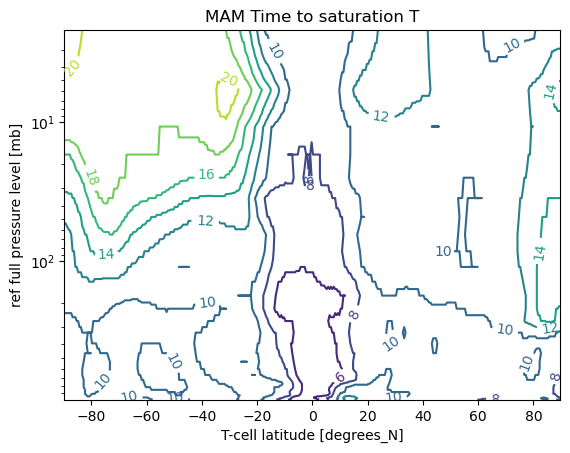

In [25]:
CS = zonal_tts.temp.plot.contour(levels=10,x='grid_yt',y='pfull',yincrease=False,yscale='log')
plt.gca().clabel(CS, CS.levels, inline=True, fontsize=10)
plt.gca().set_title(f"{NAME} Time to saturation T")
plt.savefig(f"{NAME}/{NAME}_tts_temp_pvlat.png")

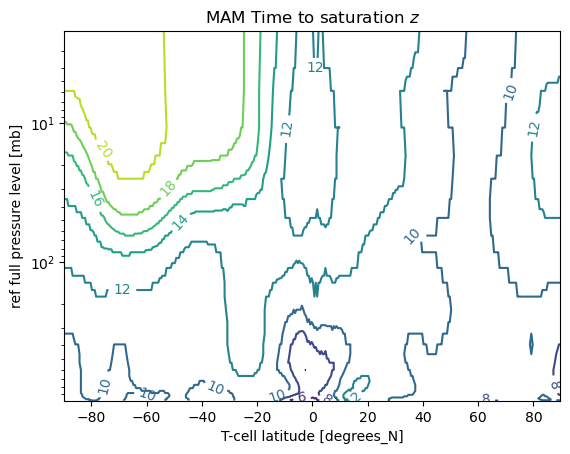

In [26]:
CS = zonal_tts.hght.plot.contour(levels=10,x='grid_yt',y='pfull',yincrease=False,yscale='log')
plt.gca().clabel(CS, CS.levels, inline=True, fontsize=10)
plt.gca().set_title(f"{NAME} Time to saturation $z$")
plt.savefig(f"{NAME}/{NAME}_tts_z_pvlat.png")